In [111]:
# Preprocessing
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# Modelling
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from catboost import CatBoostRegressor, Pool
from timeit import default_timer as timer

%matplotlib inline
plt.style.use("bmh")

path = Path.cwd().parent / "mdsb-2023"

In [40]:
def train_test_split_temporal(X, y, delta_threshold="60 days"):

    cutoff_date = X["date"].max() - pd.Timedelta(delta_threshold)
    mask = X["date"] <= cutoff_date
    X_train, X_valid = X.loc[mask], X.loc[~mask]
    y_train, y_valid = y[mask], y[~mask]

    return X_train, y_train, X_valid, y_valid

In [41]:
def add_lags(X, cols_to_lag=["t", "u", "vv", "nnuage4"], lag_list=[2, -24, -2]):
    X = X.copy()

    feature_columns = [col for col in X.columns if col in cols_to_lag]

    for l in lag_list:
        lag_columns = [f"{col}_lag{l}" for col in feature_columns]
        X[lag_columns] = X[feature_columns].shift(periods=l, axis=0)
        X[lag_columns] = (
            X[lag_columns]
            .interpolate(method="linear")
            .interpolate(method="bfill")
            .interpolate(method="ffill")
        )

    return X


def add_moving_average(
    X, cols_to_ma=["t", "u", "vv", "nnuage4"], window_list=[24 * 7, 24], centered=True
):
    X = X.copy()

    feature_columns = [col for col in X.columns if col in cols_to_ma]

    for w in window_list:
        ma_columns = [f"{col}_ma{w}" for col in feature_columns]
        X[ma_columns] = X[feature_columns].rolling(window=w, center=centered).mean()
        X[ma_columns] = (
            X[ma_columns]
            .interpolate(method="linear")
            .interpolate(method="bfill")
            .interpolate(method="ffill")
        )

    return X

### Define pipeline functions

In [77]:
def _encode_dates(X, col_name="date"):
    X = X.copy()

    X["month"] = X[col_name].dt.month
    X["weekday"] = X[col_name].dt.weekday
    X["hour"] = X[col_name].dt.hour

    X["month_sin"] = np.sin(2 * np.pi * X["date"].dt.month / 12)
    X["month_cos"] = np.cos(2 * np.pi * X["date"].dt.month / 12)

    X["day_sin"] = np.sin(2 * np.pi * X["date"].dt.day / X["date"].dt.days_in_month)
    X["day_cos"] = np.cos(2 * np.pi * X["date"].dt.day / X["date"].dt.days_in_month)

    X["hour_sin"] = np.sin(2 * np.pi * X["date"].dt.hour / 24)
    X["hour_cos"] = np.cos(2 * np.pi * X["date"].dt.hour / 24)

    X[["month", "weekday", "hour"]] = X[["month", "weekday", "hour"]].astype("category")

    return X.drop(columns=[col_name])


def _encode_covid(X, col_name="date"):
    X = X.copy()

    # Create masks for lockdown dates
    lockdown_1 = (X["date"] >= "2020-10-17") & (X["date"] <= "2020-12-14")

    lockdown_2 = (X["date"] >= "2020-12-15") & (X["date"] <= "2021-02-26")

    lockdown_3 = (X["date"] >= "2021-02-27") & (X["date"] <= "2021-05-02")

    X["Covid"] = 0
    X.loc[lockdown_1 | lockdown_2 | lockdown_3, "Covid"] = 1

    return X


def _merge_external_data(X, include_lags=True, include_ma=True):
    to_keep = [
        "date",
        "hnuage4",
        "t",
        "ctype4",
        "nnuage4",
        "u",
        "etat_sol",
        "perssfrai",
        "tx12",
        "cm",
        "tn12",
        "tend24",
        "vv",
        "rafper",
        "rr24",
        "hnuage2",
        "td",
        "rr3",
        "hnuage3",
        "hnuage1",
    ]

    ext_data = pd.read_csv(path / "external_data.csv", parse_dates=["date"])[to_keep]

    ext_data.drop(columns=ext_data.columns[ext_data.isna().sum() > 1000], inplace=True)

    full_date_range = pd.date_range(
        start=np.min([np.min(data.date), np.min(test.date)]),
        end=np.max([np.max(data.date), np.max(test.date)]),
        freq="H",
    )

    full_date_range = pd.DataFrame({"date": full_date_range})

    ext_data = full_date_range.merge(ext_data, on="date", how="left")

    columns_to_interpolate = ext_data.drop(columns="date").columns
    ext_data[columns_to_interpolate] = (
        ext_data[columns_to_interpolate]
        .interpolate(method="polynomial", order=3)
        .interpolate(method="bfill")
        .interpolate(method="ffill")
    )

    if include_lags:
        ext_data = add_lags(ext_data)

    if include_ma:
        ext_data = add_moving_average(ext_data)

    to_drop = [
        "vv_ma24",
        "rr24",
        "t_lag2",
        "rafper",
        "hnuage1",
        "td",
        "vv",
        "perssfrai",
        "vv_lag2",
        "u_lag-24",
        "vv_lag-2",
        "vv_lag-24",
        "u",
        "u_lag2",
    ]

    ext_data.drop(columns=to_drop, inplace=True)

    X = X.copy()

    X["date"] = X["date"].astype("datetime64[ns]")
    ext_data["date"] = ext_data["date"].astype("datetime64[ns]")

    X["orig_index"] = np.arange(X.shape[0])

    X = pd.merge_asof(X.sort_values("date"), ext_data.sort_values("date"), on="date")

    # Sort back to the original order
    X = X.sort_values("orig_index")
    del X["orig_index"]

    return X


def _gas_price_encoder(X):
    X = X.copy()
    X["gas_price"] = 1

    gas_prices = np.array(
        [
            1.22,
            1.21,
            1.22,
            1.27,
            1.31,
            1.36,
            1.4,
            1.39,
            1.4,
            1.43,
            1.45,
            1.45,
            1.46,
            1.56,
        ]
    )

    years = [
        2020,
        2020,
        2020,
        2020,
        2021,
        2021,
        2021,
        2021,
        2021,
        2021,
        2021,
        2021,
        2021,
        2021,
    ]

    months = [9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

    for i, price in enumerate(gas_prices):
        X.loc[
            (X.date.dt.month == months[i]) & (X.date.dt.year == years[i]), "gas_price"
        ] = price

    return X


def full_encode(X):
    return _encode_dates(_encode_covid(_gas_price_encoder(_merge_external_data(X))))

In [78]:
def get_pipeline():
    data_merger = FunctionTransformer(_merge_external_data, validate=False)
    covid_encoder = FunctionTransformer(_encode_covid, validate=False)
    gas_encoder = FunctionTransformer(_gas_price_encoder, validate=False)
    date_encoder = FunctionTransformer(_encode_dates, validate=False)

    best_params = {
        "learning_rate": 0.16,
        "max_depth": 8,
        "n_estimators": 630,
        "subsample": 0.8,
        "od_pval": 1e-5,
    }

    regressor = CatBoostRegressor(**best_params)

    pipe = Pipeline(
        [
            ("merge external", data_merger),
            ("gas prices encoder", gas_encoder),
            ("covid encoder", covid_encoder),
            ("date encoder", date_encoder),
            ("regressor", regressor),
        ]
    )

    return pipe

## Import main dataset

In [133]:
data = pd.read_parquet(path / "train.parquet")
test = pd.read_parquet(path / "final_test.parquet")

targets = ["bike_count", "log_bike_count"]

In [134]:
mask1 = (data.counter_name == "20 Avenue de Clichy NO-SE") | (
    data.counter_name == "20 Avenue de Clichy SE-NO"
)
mask2 = (data.date > pd.to_datetime("2021/05/06")) & (
    data.date < pd.to_datetime("2021/07/21")
)

data.loc[mask1 & mask2, "log_bike_count"] = data["log_bike_count"].mean()

In [135]:
data.drop(
    columns=[
        "site_name",
        "counter_id",
        "site_id",
        "counter_installation_date",
        "coordinates",
        "counter_technical_id",
    ],
    inplace=True,
)

test.drop(
    columns=[
        "site_name",
        "counter_id",
        "site_id",
        "counter_installation_date",
        "coordinates",
        "counter_technical_id",
    ],
    inplace=True,
)

## Model

In [136]:
X, y = data.drop(columns=targets), data["log_bike_count"]

date_cols = (
    _encode_dates(X[["date"]]).select_dtypes(include="category").columns.tolist()
)
categorical_cols = ["counter_name"] + date_cols

In [137]:
X_train, y_train, X_test, y_test = train_test_split_temporal(X, y)

print(
    f'Train: n_samples={X_train.shape[0]},  {X_train["date"].min()} to {X_train["date"].max()}'
)
print(
    f'Test: n_samples={X_test.shape[0]},  {X_test["date"].min()} to {X_test["date"].max()}'
)

Train: n_samples=416187,  2020-09-01 01:00:00 to 2021-07-11 23:00:00
Test: n_samples=80640,  2021-07-12 00:00:00 to 2021-09-09 23:00:00


In [138]:
pipe = get_pipeline()

val_pool = Pool(
    full_encode(X_test),
    label=y_test,
    cat_features=categorical_cols,
)

pipe.fit(
    X_train,
    y_train,
    regressor__cat_features=categorical_cols,
    regressor__early_stopping_rounds=70,
    regressor__eval_set=val_pool,
)

0:	learn: 1.4823426	test: 1.2700230	best: 1.2700230 (0)	total: 1.31s	remaining: 13m 42s
1:	learn: 1.3166708	test: 1.1157923	best: 1.1157923 (1)	total: 2.24s	remaining: 11m 43s
2:	learn: 1.1818210	test: 0.9940306	best: 0.9940306 (2)	total: 3.24s	remaining: 11m 17s
3:	learn: 1.0765233	test: 0.9019602	best: 0.9019602 (3)	total: 4.12s	remaining: 10m 44s
4:	learn: 0.9887589	test: 0.8286120	best: 0.8286120 (4)	total: 4.88s	remaining: 10m 10s
5:	learn: 0.9159193	test: 0.7701899	best: 0.7701899 (5)	total: 5.79s	remaining: 10m 2s
6:	learn: 0.8599626	test: 0.7322548	best: 0.7322548 (6)	total: 6.62s	remaining: 9m 49s
7:	learn: 0.8171369	test: 0.7044536	best: 0.7044536 (7)	total: 7.49s	remaining: 9m 42s
8:	learn: 0.7829951	test: 0.6830816	best: 0.6830816 (8)	total: 8.3s	remaining: 9m 32s
9:	learn: 0.7514165	test: 0.6706352	best: 0.6706352 (9)	total: 9.4s	remaining: 9m 42s
10:	learn: 0.7204850	test: 0.6591457	best: 0.6591457 (10)	total: 10.1s	remaining: 9m 26s
11:	learn: 0.6962331	test: 0.6483671	b

Pipeline(steps=[('merge external',
                 FunctionTransformer(func=<function _merge_external_data at 0x0000021691D70CA0>)),
                ('gas prices encoder',
                 FunctionTransformer(func=<function _gas_price_encoder at 0x0000021691D71000>)),
                ('covid encoder',
                 FunctionTransformer(func=<function _encode_covid at 0x0000021691D70550>)),
                ('date encoder',
                 FunctionTransformer(func=<function _encode_dates at 0x0000021690315480>)),
                ('regressor',
                 <catboost.core.CatBoostRegressor object at 0x0000021769B843D0>)])

In [139]:
y_hat = pipe.predict(X_test)
y_hat[y_hat < 0] = 0

print(
    f"Train set, RMSE={mean_squared_error(y_train, pipe.predict(X_train), squared=False):.2f}"
)
print(f"Test set, RMSE={mean_squared_error(y_test, y_hat, squared=False):.2f}")

Train set, RMSE=0.40
Test set, RMSE=0.55


## Feature Importance

CatBoost feature importance:

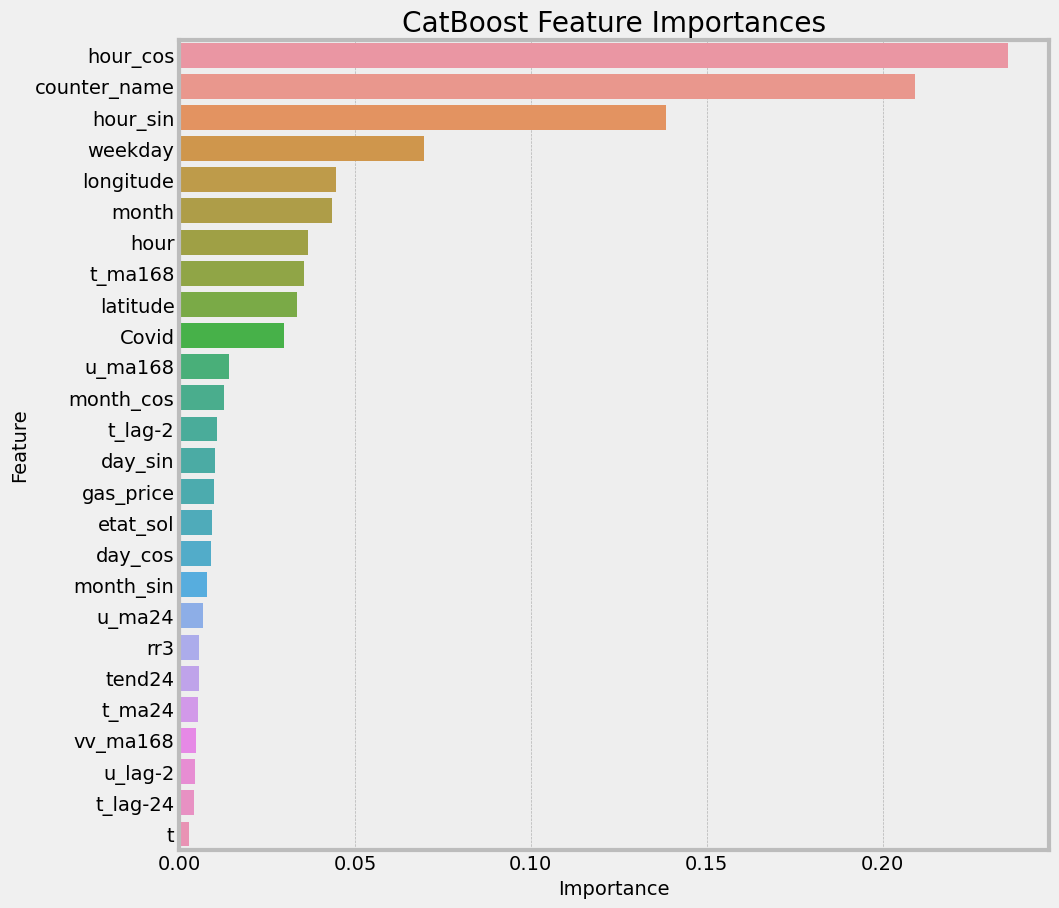

In [140]:
feature_names = full_encode(
    X_test
).columns.tolist()  # Assuming encode functions keep column names

# Combine feature names and importances
feature_importances = pd.DataFrame(
    {
        "Feature": feature_names,
        "Importance": np.abs(pipe.named_steps["regressor"].feature_importances_)
        / (np.sum(np.abs(pipe.named_steps["regressor"].feature_importances_))),
    }
)

# Sort by importance
feature_importances = feature_importances.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 10))
sns.barplot(x="Importance", y="Feature", data=feature_importances.iloc[:, :])
plt.title("CatBoost Feature Importances")
plt.show()

Feature importance with shap:

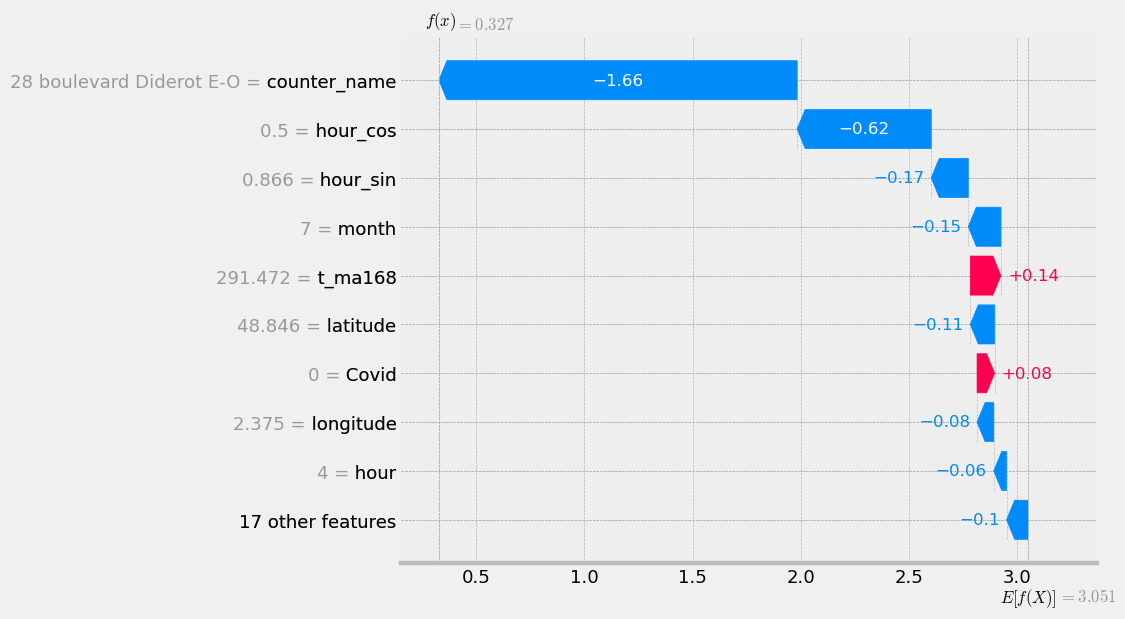

In [143]:
explainer = shap.Explainer(pipe.named_steps["regressor"])

shap_values = explainer(full_encode(X_test))

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

## Prediction visualization

In [141]:
rmse_per_counter = []

for c in X_test["counter_name"].unique():
    # Filter predictions and actual values based on the counter
    y_hat_counter = y_hat[X_test["counter_name"] == c]
    y_test_counter = y_test[X_test["counter_name"] == c]

    # Calculate RMSE for the current counter
    rmse = mean_squared_error(y_test_counter, y_hat_counter, squared=False)

    # Store results in the list
    rmse_per_counter.append({"Counter": c, "Test set RMSE": rmse})

# Convert the list to a DataFrame
rmse_per_counter = pd.DataFrame(rmse_per_counter)

# Sort the DataFrame based on the "Counter" column
rmse_per_counter = rmse_per_counter.sort_values(by="Test set RMSE", ascending=False)

# Print the sorted table
print(rmse_per_counter)

                                            Counter  Test set RMSE
50                           90 Rue De Sèvres NE-SO       1.078865
52                        20 Avenue de Clichy NO-SE       0.811984
51                           90 Rue De Sèvres SO-NE       0.788711
53                        20 Avenue de Clichy SE-NO       0.786337
0                          28 boulevard Diderot E-O       0.761680
24                          Pont de la Concorde S-N       0.685705
25                           Pont des Invalides N-S       0.668555
35                     Face au 40 quai D'Issy SO-NE       0.634328
46                         Totem Cours la Reine E-O       0.617199
6                       Voie Georges Pompidou NE-SO       0.615548
47                         Totem Cours la Reine O-E       0.613434
34                     Face au 40 quai D'Issy NE-SO       0.600386
1                          28 boulevard Diderot O-E       0.590468
16                         6 rue Julia Bartet SO-NE       0.58

Plot predictions for counters with worst residuals

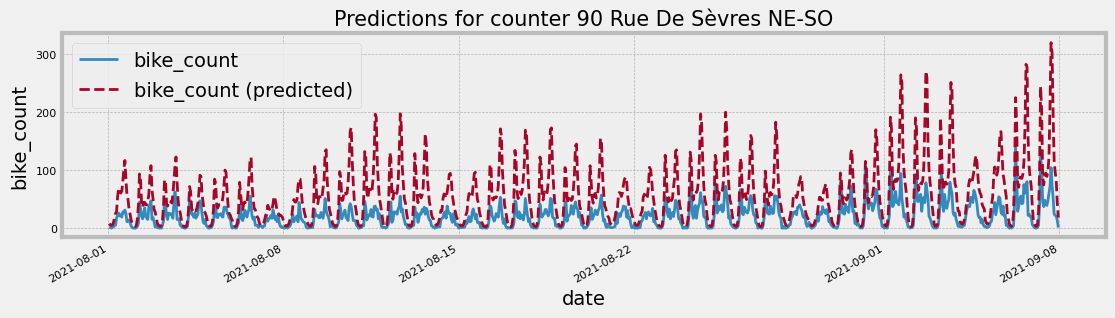

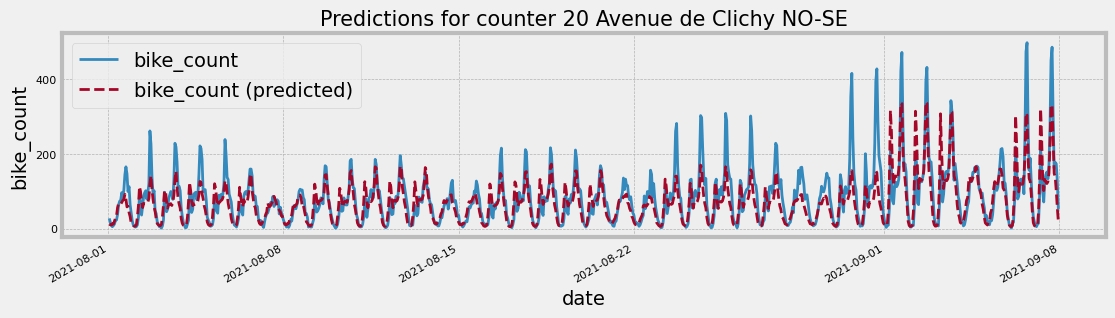

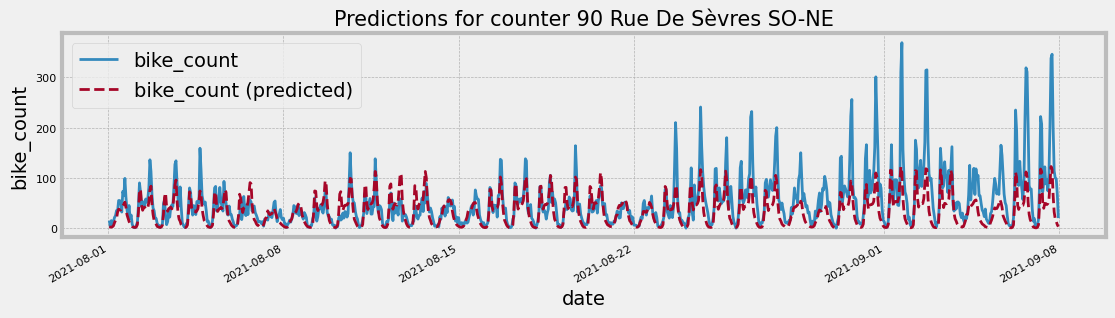

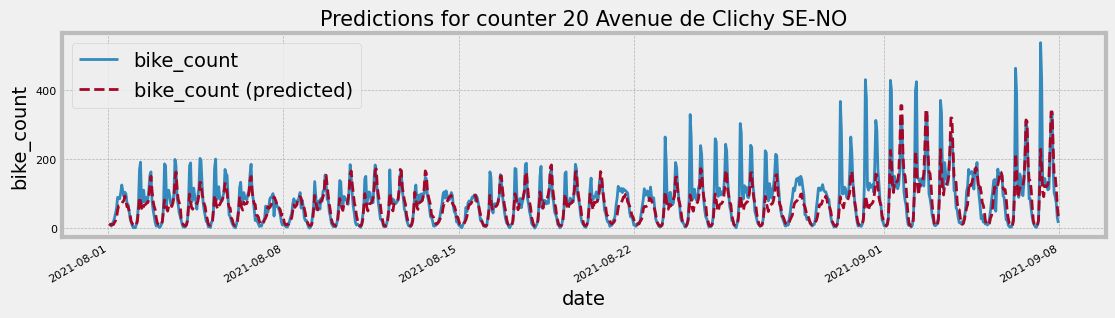

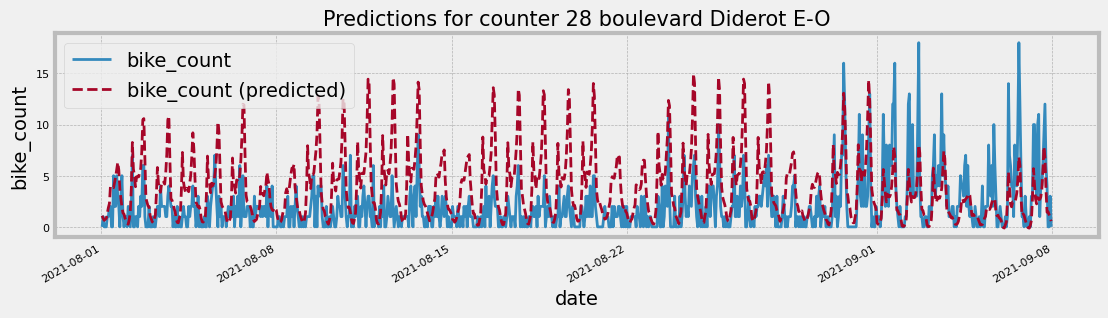

In [142]:
for c in rmse_per_counter["Counter"].iloc[:5]:
    mask = (
        (X_test["counter_name"] == c)
        & (X_test["date"] > pd.to_datetime("2021/08/01"))
        & (X_test["date"] < pd.to_datetime("2021/09/08"))
    )

    df_viz = X_test.loc[mask].copy()
    df_viz["bike_count"] = np.exp(y_test[mask.values]) - 1
    df_viz["bike_count (predicted)"] = np.exp(pipe.predict(X_test[mask])) - 1

    fig, ax = plt.subplots(figsize=(12, 3))

    df_viz.plot(x="date", y="bike_count", ax=ax)
    df_viz.plot(x="date", y="bike_count (predicted)", ax=ax, ls="--")
    ax.set_title(f"Predictions for counter {c}", fontsize=15)
    ax.set_ylabel("bike_count")
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.show()